In [101]:
from torch.nn import Sequential
from torch.nn import Linear, Dropout, ReLU
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import MSELoss, HuberLoss
from torch.optim import SGD, Adam

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import json
import os

from Module.MySQL_connector import MySQLConnector

In [223]:
import torch

from torch.optim import SGD

class SimpleTrainer:
    """A model trainer for regression models."""

    def __init__(self, model, loss_fn, optimizer):
        self.model = self.to_gpu(model)
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def to_gpu(self, obj, device="cuda:0"):
        """將張量或模型送至GPU。"""
        return obj.to(device)

    def train_step(self, dataloader):
        """訓練一個epoch，並計算 R²。"""
        self.model.train()  # 設定成訓練模式
        total_loss = 0  # 累積所有 batch 的損失
        total_r2 = 0  # 累積所有 batch 的 R²

        for iteration, (batch_x, batch_y) in enumerate(dataloader):
            batch_x = self.to_gpu(batch_x)
            batch_y = self.to_gpu(batch_y)

            self.optimizer.zero_grad()  # 清空模型內所有權重的梯度

            pred_y = self.model(batch_x)  # 正向傳遞得到模型預測

            loss_value = self.loss_fn(pred_y, batch_y)  # 計算損失

            for weight in self.model.parameters():
                loss_value += 0.01* torch.sum(weight**2)
                # print(loss_value,  torch.sum(weight)**2)

            loss_value.backward()  # 反向傳遞
            self.optimizer.step()  # 更新權重

            total_loss += loss_value.item()  # 累積損失

            # 计算 R²
            ss_total = torch.sum((batch_y - torch.mean(batch_y)) ** 2)
            ss_residual = torch.sum((batch_y - pred_y) ** 2)
            r2 = 1 - ss_residual / ss_total
            total_r2 += r2.item()

        avg_loss = total_loss / len(dataloader)  # 計算平均損失
        avg_r2 = total_r2 / len(dataloader)  # 平均 R²
        print(f"Train loss: {avg_loss:.4f}, Train R²: {avg_r2:.4f}")
        return avg_loss, avg_r2

    def test_step(self, dataloader, mode="test"):
        """結束一個epoch的訓練後，測試模型表現。"""
        self.model.eval()  # 設定成推理模式

        size = len(dataloader.dataset)
        test_loss = 0
        total_r2 = 0

        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x = self.to_gpu(batch_x)
                batch_y = self.to_gpu(batch_y)

                pred_y = self.model(batch_x)

                # 计算损失
                test_loss += self.loss_fn(pred_y, batch_y).item()

                # 计算 R²
                ss_total = torch.sum((batch_y - torch.mean(batch_y)) ** 2)
                ss_residual = torch.sum((batch_y - pred_y) ** 2)
                r2 = 1 - ss_residual / ss_total
                total_r2 += r2.item()

        avg_test_loss = test_loss / len(dataloader)  # 計算平均測試損失
        avg_r2 = total_r2 / len(dataloader)  # 平均 R²
        print(f"{mode}_loss={avg_test_loss:.4f}, {mode}_R²={avg_r2:.4f}")
        return avg_test_loss, avg_r2

    def fit(self, dataloader_train, dataloader_test, num_epochs):
        # 開始訓練
        metrics = {"train_loss": [], "test_loss": [], "train_r2": [], "test_r2": []}
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_loss, train_r2 = self.train_step(dataloader_train)
            test_loss, test_r2 = self.test_step(dataloader_test)

            metrics["train_loss"].append(train_loss)
            metrics["test_loss"].append(test_loss)
            metrics["train_r2"].append(train_r2)
            metrics["test_r2"].append(test_r2)

        return metrics

    def __call__(self, x):
        self.model.eval()  # 啟動推理模式
        return self.model(x)  # 執行推理


In [178]:
import torch
from torch.nn import MSELoss
from torch.optim import SGD

class SimpleTrainer:
    """A model trainer for regression models."""

    def __init__(self, model, loss_fn, optimizer):
        self.model = self.to_gpu(model)
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def to_gpu(self, obj, device="cuda:0"):
        """將張量或模型送至GPU。"""
        return obj.to(device)

    def train_step(self, dataloader):
        """訓練一個epoch。"""
        self.model.train()  # 設定成訓練模式
        total_loss = 0  # 累積所有 batch 的損失
        for iteration, (batch_x, batch_y) in enumerate(dataloader):
            batch_x = self.to_gpu(batch_x)
            batch_y = self.to_gpu(batch_y)
            # print(batch_x.shape)
            self.optimizer.zero_grad()  # 清空模型內所有權重的梯度

            pred_y = self.model(batch_x)  # 正向傳遞得到模型預測
            # print(pred_y.shape)
            loss_value = self.loss_fn(pred_y, batch_y)  # 計算損失
            loss_value.backward()  # 反向傳遞
            self.optimizer.step()  # 更新權重

            total_loss += loss_value.item()  # 累積損失

        avg_loss = total_loss / len(dataloader)  # 計算平均損失
        print(f"Train loss: {avg_loss:.4f}")
        return avg_loss

    def test_step(self, dataloader, mode="test"):
        """結束一個epoch的訓練後，測試模型表現。"""
        self.model.eval()  # 設定成推理模式

        size = len(dataloader.dataset)
        test_loss = 0
        total_r2 = 0

        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x = self.to_gpu(batch_x)
                batch_y = self.to_gpu(batch_y)

                pred_y = self.model(batch_x)

                # 计算损失
                test_loss += self.loss_fn(pred_y, batch_y).item()

                # 计算 R²
                ss_total = torch.sum((batch_y - torch.mean(batch_y)) ** 2)
                ss_residual = torch.sum((batch_y - pred_y) ** 2)
                r2 = 1 - ss_residual / ss_total
                total_r2 += r2.item()

        avg_test_loss = test_loss / len(dataloader)  # 計算平均測試損失
        avg_r2 = total_r2 / len(dataloader)  # 平均 R²
        print(f"{mode}_loss={avg_test_loss:.4f}, {mode}_R2={avg_r2:.4f}")
        return avg_r2

    def fit(self, dataloader_train, dataloader_test, num_epochs):
        # 開始訓練
        metrics = {"train_loss": [], "test_loss": [], "train_r2": [], "test_r2": []}
        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_loss = self.train_step(dataloader_train)
            test_r2 = self.test_step(dataloader_test)

            metrics["train_loss"].append(train_loss)
            metrics["test_r2"].append(test_r2)

        return metrics

    def __call__(self, x):
        self.model.eval()  # 啟動推理模式
        return self.model(x)  # 執行推理


In [5]:
# import data from MySQL
sql_connector = MySQLConnector('192.168.31.130', 'bigred', 'bigred', 32010)
sql_connector.connectDB('g3_db')
# print(sql_connector.execute_query('show tables;'))
sql_connector.execute_query('show tables;')
main_table = pd.DataFrame(sql_connector.execute_query("select * from main_aa"))
genres_onehot = pd.DataFrame(sql_connector.execute_query("select * from genres_onehot_aa"))
features_onehot = pd.DataFrame(sql_connector.execute_query("select * from features_onehot_aa"))
tags_onehot = pd.DataFrame(sql_connector.execute_query("select * from tags_onehot_aa"))
id_publisher_aa = pd.DataFrame(sql_connector.execute_query("select * from id_publishers_aa"))
publishers_info_aa = pd.DataFrame(sql_connector.execute_query("select * from publishers_info_aa;"))
copiesold = pd.DataFrame(sql_connector.execute_query("select * from first30days_sales_2A"))

Connected to g3_db on 192.168.31.130:32010


In [7]:
# 合併時指定 suffixes 參數來處理重複列
merged_table = pd.merge(main_table, genres_onehot, on='steamId', suffixes=('', '_genres'))
merged_table = pd.merge(merged_table, tags_onehot, on='steamId', suffixes=('', '_tags'))
# 再次合併時，處理更多的重複列
merged_table = pd.merge(merged_table, features_onehot, on='steamId', suffixes=('', '_features'))
# 找到所有帶有 '_tags' 或 '_features' 後綴的列名
replicated_columns = [col for col in merged_table.columns if '_tags' in col or '_features' in col]

# 刪除這些列
merged_table.drop(columns=replicated_columns, inplace=True)

In [9]:
cs_pub = pd.merge(copiesold,id_publisher_aa,on="steamId")
# cs_pub_info = pd.merge(cs_pub, publishers_info_aa, on="steamId")
cs_pub_info = pd.merge(cs_pub, publishers_info_aa, left_on='publisher', right_on="name")
cs_pub_info
cs_pub_info=cs_pub_info.dropna()

In [46]:
full_table = pd.merge(cs_pub_info, merged_table, on="steamId",suffixes=('', '_pub'))

In [47]:
columns_to_drop = ['steamId','totalRevenue_pub','publisher','name_pub','name','reviews','reviewsSteam','followers','avgPlaytime','reviewScore','releaseDate','firstReleaseDate','copiesSold','revenue','totalRevenue','players','owners','wishlists']
full_table=full_table.drop(columns=columns_to_drop)

In [48]:

full_table = full_table.dropna()
full_table[['publishedGames','medianRevenue','averageRevenue']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1244 entries, 0 to 1243
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publishedGames  1244 non-null   int64  
 1   medianRevenue   1244 non-null   float64
 2   averageRevenue  1244 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 29.3 KB


In [49]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 初始化 MinMaxScaler
scaler = MinMaxScaler()

full_table['sales'] = np.log1p(full_table['sales'])
full_table['publishedGames'] = np.log1p(full_table['publishedGames'])
full_table['medianRevenue'] = np.log1p(full_table['medianRevenue'])
# 選擇要正規化的欄位
columns_to_scale = ["price", "publishedGames", "medianRevenue", "averageRevenue"]

# 對指定欄位進行 Min-Max 轉換
full_table[columns_to_scale] = scaler.fit_transform(full_table[columns_to_scale])
# full_table['sales'] = np.log1p(full_table['sales'])
# full_table 中的這些欄位現在已經進行 Min-Max 正規化
print(full_table.head())

       sales            timeStamp  days_since_release  averageRevenue  \
0   0.000000  2019-09-02 15:00:00                  30        0.011630   
1  10.949297  2019-09-02 15:00:00                  30        0.011630   
2  12.098669  2015-07-17 13:00:00                  30        0.100861   
3  13.910367  2015-05-05 09:00:00                  30        0.054163   
4  10.895628  2016-06-01 20:00:00                  30        0.027177   

   medianRevenue  publishedGames     price  releaseDate_pub  earlyAccess  \
0       0.313861        0.920853  0.074884    1567137600000            0   
1       0.313861        0.920853  0.074884    1567137600000            0   
2       0.729617        0.333030  0.249906    1435032000000            0   
3       0.466836        0.396728  0.499937    1430107200000            0   
4       0.484056        0.639981  0.249906    1463457600000            0   

   Action  ...  Steam Cloud  Steam Leaderboards  Steam Trading Cards  \
0       1  ...            0     

In [51]:
full_table = full_table.drop(columns=["days_since_release","releaseDate_pub","timeStamp"])



In [54]:
X_full = full_table.drop(columns="sales").values
Y_full = full_table['sales'].values

In [52]:
full_table

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Action,Adventure,Casual,Early Access,...,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled
0,0.000000,0.011630,0.313861,0.920853,0.074884,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.949297,0.011630,0.313861,0.920853,0.074884,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.098669,0.100861,0.729617,0.333030,0.249906,0,1,1,0,0,...,1,1,1,0,0,0,0,0,0,0
3,13.910367,0.054163,0.466836,0.396728,0.499937,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
4,10.895628,0.027177,0.484056,0.639981,0.249906,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,13.865232,0.036138,0.580738,0.306951,0.099887,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1240,8.429891,0.004767,0.283533,0.717103,0.749969,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1241,11.482043,0.014553,0.341670,0.712718,0.249906,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1242,7.859799,0.004767,0.283533,0.717103,0.499937,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0


In [143]:
from sklearn.decomposition import PCA

# 1. 應用 PCA
pca = PCA(n_components=0.95)  # 保留 95% 的變異性
X_pca = pca.fit_transform(X_full)

In [144]:
pd.DataFrame(X_pca)

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
0,-0.958634,1.381461,0.393285,0.331731,-1.208069,-0.459941,-0.229845,-0.986522,-0.502040,0.001096,...,0.019197,-0.137273,-0.119302,-0.065011,-0.051771,0.086889,0.018763,0.080927,0.104578,-0.010458
1,-0.958634,1.381461,0.393285,0.331731,-1.208069,-0.459941,-0.229845,-0.986522,-0.502040,0.001096,...,0.019197,-0.137273,-0.119302,-0.065011,-0.051771,0.086889,0.018763,0.080927,0.104578,-0.010458
2,1.053934,0.743290,0.117340,-0.976509,-0.080199,-1.026414,0.939825,-0.474286,0.056530,0.736193,...,-0.089179,0.041706,-0.052216,0.056904,0.047004,0.115403,-0.017493,-0.047417,-0.019444,-0.138522
3,-0.581212,-0.390878,0.897361,-0.611077,0.826489,-0.026942,-0.160297,-1.470252,-0.044766,0.811961,...,-0.108880,0.137031,-0.007164,0.282209,-0.089450,-0.195839,0.171350,-0.052936,-0.050460,-0.092297
4,-0.142500,1.160684,-0.012679,-1.560976,-0.666818,-0.337330,0.640182,-0.088641,-0.303344,-0.196894,...,-0.051213,0.023905,0.037628,-0.103024,-0.132994,0.039577,-0.112722,-0.005092,0.080923,-0.069105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,-0.295878,1.144732,1.196059,-1.025700,-0.858526,0.425925,0.260954,1.179354,-0.213090,0.025175,...,0.018486,0.347347,0.390136,0.033045,-0.091125,-0.068043,-0.134452,0.082871,-0.214248,-0.097932
1240,1.362531,0.195780,-0.030295,-0.700239,-0.034225,-0.494802,-0.223845,0.795331,0.749374,0.373240,...,0.094645,-0.057417,-0.141879,-0.072635,0.076430,-0.051944,0.133079,0.063694,0.030252,-0.068081
1241,-1.086280,1.119930,-0.436171,-0.662856,-0.309996,0.034728,0.237060,0.388083,0.606347,-0.503221,...,-0.248914,-0.294603,-0.086432,-0.123298,-0.099795,0.128806,0.052561,0.041710,-0.023201,-0.072632
1242,0.670831,0.672811,-0.279929,0.056136,0.131138,-0.163586,-0.706235,0.218882,1.231441,0.746694,...,0.018647,-0.148918,0.009707,-0.000926,-0.023227,0.078115,-0.118050,0.090323,0.007409,0.045811


In [145]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 25)
# X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, Y_full, test_size = 0.3, random_state = 25)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_pca, Y_full, test_size = 0.3, random_state = 25)

In [146]:
x_train, y_train = torch.tensor(X_train_full), torch.tensor(y_train_full)
x_test, y_test = torch.tensor(X_test_full), torch.tensor(y_test_full)
x_train = x_train.to(torch.float32)
x_test = x_test.to(torch.float32)
y_train = y_train.to(torch.float32)
y_test = y_test.to(torch.float32)
# 將PyTorch tensor 製作成 Data Loader
td = TensorDataset(x_train, y_train)
dl_train = DataLoader(td, batch_size=128, shuffle=True)
# Shuffle 隨機打亂數據，防止模型過度依賴數據的順序，從而提高模型的泛化能力。
td = TensorDataset(x_test, y_test)
dl_test = DataLoader(td, batch_size=128, shuffle=False)

In [147]:
for x_batch, y_batch in dl_train:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([128, 220]) torch.Size([128])


In [148]:
print(f"Shape of X_train:{X_train_full.shape}")
print(f"Shape of X_test:{X_test_full.shape}")
print(f"Shape of y_train:{y_train_full.shape}")
print(f"Shape of y_test{y_test_full.shape}")

Shape of X_train:(870, 220)
Shape of X_test:(374, 220)
Shape of y_train:(870,)
Shape of y_test(374,)


TypeError: linear(): argument 'input' (position 1) must be Tensor, not torch.Size

In [226]:
from torch import nn
layers = [ 
    Linear(220, 1),  # 增加神經元數量
    # ReLU(),
    # nn.BatchNorm1d(2048),
    # Linear(2048, 1)   # 增加一層
    # ReLU(),
    # nn.BatchNorm1d(64),
    # Linear(64, 32),
    # ReLU(),
    # nn.BatchNorm1d(32),
    # Linear(32, 32),
    # ReLU(),
    # nn.BatchNorm1d(32),
    # Linear(32, 32),
    # ReLU(),
    # nn.BatchNorm1d(32),
    # Linear(32, 32),
    # ReLU(),
    # nn.BatchNorm1d(32),
    # Linear(32, 32),
    # ReLU(),
    # nn.BatchNorm1d(32),
    # Linear(32, 1)
]
# layers = [
#     nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3, padding=1),  # Conv1d 层替代 Linear 层
#     nn.ReLU(),
#     nn.Conv1d(in_channels=50, out_channels=32, kernel_size=3, padding=1), # 第二层 Conv1d
#     nn.ReLU(),
#     nn.Conv1d(in_channels=32, out_channels=1, kernel_size=1)  # 输出层 Conv1d
# ]
model = Sequential(*layers)

In [227]:
x,y = next(iter(dl_train))
model(x).shape

torch.Size([128, 1])

In [228]:
# 宣告模型訓練設定
num_epochs = 1200
learning_rate = 0.001

# 定義優化器, Loss函數
loss = MSELoss()
opt = Adam(model.parameters(), lr=learning_rate)

# 開始訓練模|型
model = SimpleTrainer(model, loss, opt)
metrics = model.fit(dl_train, dl_test, num_epochs=num_epochs)

Epoch 1/1200
Train loss: 96.1115, Train R²: -2244.4290
test_loss=94.4760, test_R²=-2241.8816
Epoch 2/1200
Train loss: 96.1133, Train R²: -2254.6456
test_loss=94.4116, test_R²=-2240.3545
Epoch 3/1200
Train loss: 95.7271, Train R²: -2230.4098
test_loss=94.3439, test_R²=-2238.7403
Epoch 4/1200
Train loss: 95.4710, Train R²: -2241.3264
test_loss=94.2748, test_R²=-2237.0986
Epoch 5/1200
Train loss: 95.4130, Train R²: -2219.9928
test_loss=94.2092, test_R²=-2235.5343
Epoch 6/1200
Train loss: 95.2275, Train R²: -2235.3315
test_loss=94.1413, test_R²=-2233.9242
Epoch 7/1200
Train loss: 95.1365, Train R²: -2219.8438
test_loss=94.0700, test_R²=-2232.2289
Epoch 8/1200
Train loss: 94.9759, Train R²: -2212.2067
test_loss=94.0028, test_R²=-2230.6329
Epoch 9/1200
Train loss: 94.8984, Train R²: -2207.6866
test_loss=93.9383, test_R²=-2229.0921
Epoch 10/1200
Train loss: 94.7615, Train R²: -2209.5678
test_loss=93.8691, test_R²=-2227.4482
Epoch 11/1200
Train loss: 94.6321, Train R²: -2258.6819
test_loss=93.

In [229]:
metrics = model.fit(dl_train, dl_test, num_epochs=num_epochs)

Epoch 1/1200
Train loss: 11.0782, Train R²: -242.3925
test_loss=14.0417, test_R²=-333.0180
Epoch 2/1200
Train loss: 11.1800, Train R²: -240.6142
test_loss=14.0059, test_R²=-332.1652
Epoch 3/1200
Train loss: 11.0563, Train R²: -239.3392
test_loss=13.9704, test_R²=-331.3139
Epoch 4/1200
Train loss: 11.0908, Train R²: -239.8276
test_loss=13.9350, test_R²=-330.4707
Epoch 5/1200
Train loss: 11.1064, Train R²: -242.1052
test_loss=13.8992, test_R²=-329.6165
Epoch 6/1200
Train loss: 10.9891, Train R²: -239.4359
test_loss=13.8637, test_R²=-328.7681
Epoch 7/1200
Train loss: 10.9774, Train R²: -242.6008
test_loss=13.8280, test_R²=-327.9183
Epoch 8/1200
Train loss: 10.9930, Train R²: -236.4871
test_loss=13.7927, test_R²=-327.0746
Epoch 9/1200
Train loss: 10.9515, Train R²: -236.7240
test_loss=13.7562, test_R²=-326.2046
Epoch 10/1200
Train loss: 10.9469, Train R²: -236.8241
test_loss=13.7212, test_R²=-325.3695
Epoch 11/1200
Train loss: 10.9958, Train R²: -238.7611
test_loss=13.6863, test_R²=-324.53

In [230]:
metrics = model.fit(dl_train, dl_test, num_epochs=num_epochs)

Epoch 1/1200
Train loss: 6.3398, Train R²: -124.0948
test_loss=5.3566, test_R²=-124.5194
Epoch 2/1200
Train loss: 6.2844, Train R²: -124.6494
test_loss=5.3565, test_R²=-124.5162
Epoch 3/1200
Train loss: 6.2779, Train R²: -124.6495
test_loss=5.3564, test_R²=-124.5136
Epoch 4/1200
Train loss: 6.3428, Train R²: -124.2243
test_loss=5.3564, test_R²=-124.5149
Epoch 5/1200
Train loss: 6.3442, Train R²: -124.0692
test_loss=5.3564, test_R²=-124.5156
Epoch 6/1200
Train loss: 6.3082, Train R²: -124.6401
test_loss=5.3565, test_R²=-124.5163
Epoch 7/1200
Train loss: 6.2989, Train R²: -124.2561
test_loss=5.3565, test_R²=-124.5171
Epoch 8/1200
Train loss: 6.3303, Train R²: -124.1977
test_loss=5.3565, test_R²=-124.5163
Epoch 9/1200
Train loss: 6.3260, Train R²: -124.0054
test_loss=5.3564, test_R²=-124.5149
Epoch 10/1200
Train loss: 6.2949, Train R²: -123.9358
test_loss=5.3564, test_R²=-124.5148
Epoch 11/1200
Train loss: 6.2956, Train R²: -124.0175
test_loss=5.3564, test_R²=-124.5165
Epoch 12/1200
Train

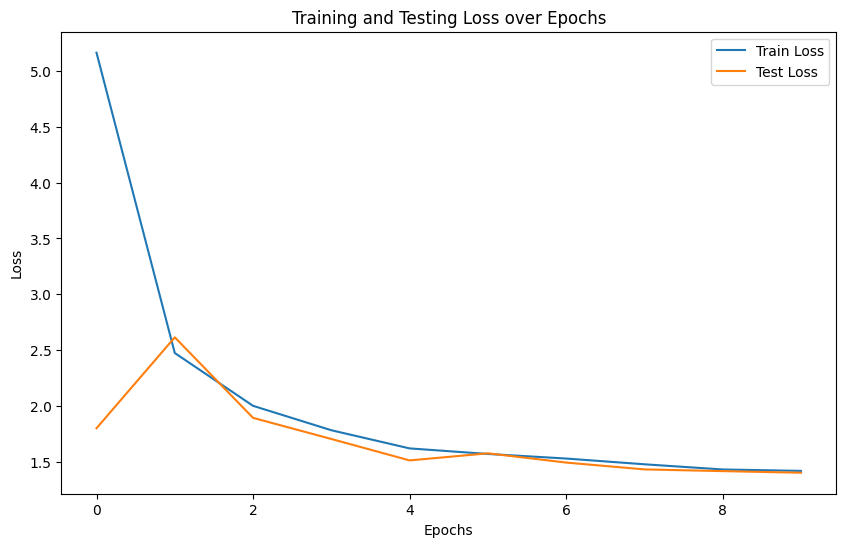

In [124]:
import matplotlib.pyplot as plt

# 假设 metrics 字典已经有 'train_loss' 和 'test_loss'
# 这些是从 trainer.fit() 返回的
train_loss = metrics["train_loss"]
test_loss = metrics["test_loss"]

# 画出训练损失和测试损失的曲线
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")

# 设置标题和标签
plt.title("Training and Testing Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")

# 添加图例
plt.legend()

# 显示图表
plt.show()


In [36]:
full_table.drop(columns="sales")

array([[0.01163047, 0.00232218, 0.6961326 , ..., 0.        , 0.        ,
        0.        ],
       [0.01163047, 0.00232218, 0.6961326 , ..., 0.        , 0.        ,
        0.        ],
       [0.10086137, 0.09390121, 0.03867403, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.01455339, 0.00300526, 0.26519337, ..., 0.        , 0.        ,
        0.        ],
       [0.00476716, 0.00174412, 0.27071823, ..., 0.        , 0.        ,
        0.        ],
       [0.00424864, 0.00119572, 0.48066298, ..., 0.        , 0.        ,
        0.        ]])

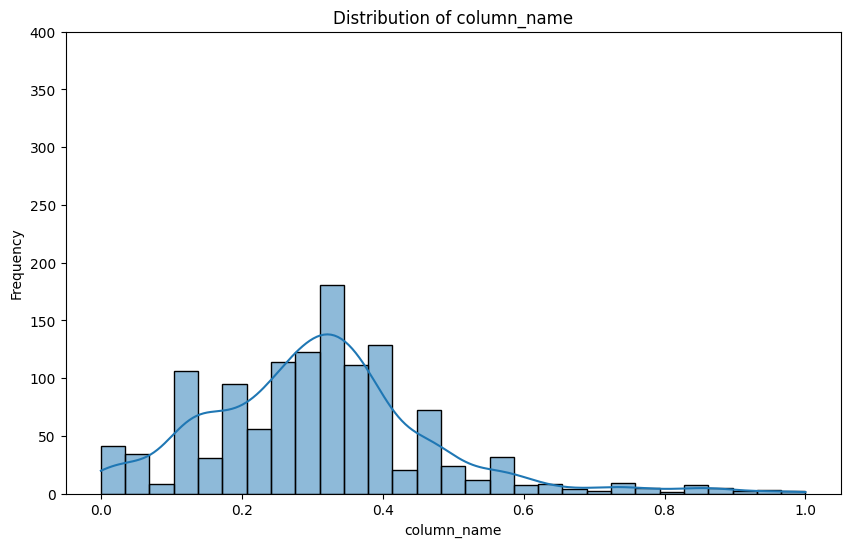

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假設你要繪製 df['column_name'] 的分布
plt.figure(figsize=(10, 6))
sns.histplot(full_table.drop(columns="sales")["medianRevenue"], kde=True)  # kde=True 可以添加密度估計曲線
plt.title('Distribution of column_name')
plt.xlabel('column_name')
plt.ylabel('Frequency')
plt.ylim(0, 400)
plt.show()

In [44]:
full_table

,sales,averageRevenue,medianRevenue,publishedGames,price,earlyAccess,Action,Adventure,Casual,Early Access,...,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Controller Support,VR Only,VR Supported,Valve Anti-Cheat enabled
0,0.000000,0.011630,0.002322,0.696133,0.074884,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.949297,0.011630,0.002322,0.696133,0.074884,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12.098669,0.100861,0.093901,0.038674,0.249906,0,1,1,0,0,...,1,1,1,0,0,0,0,0,0,0
3,13.910367,0.054163,0.009294,0.055249,0.499937,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0,0
4,10.895628,0.027177,0.010831,0.187845,0.249906,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,13.865232,0.036138,0.025433,0.033149,0.099887,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1240,8.429891,0.004767,0.001744,0.270718,0.749969,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1241,11.482043,0.014553,0.003005,0.265193,0.249906,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
1242,7.859799,0.004767,0.001744,0.270718,0.499937,0,1,1,0,0,...,1,0,1,0,0,0,0,0,0,0
